In [3]:
import pygeohash as gh
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

%load_ext autoreload
%autoreload 2

sys.path.append(os.path.dirname(sys.path[0]))

from uk_road_safety.python.data_cleaning import prepare_data_for_groupby
from uk_road_safety.python.data_cleaning import prepare_data
from uk_road_safety.python.grouped_data import data_for_analysis
from uk_road_safety.python import mlmodel
import tensorflow as tf

import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
df_accidents=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/preprocessed-1999-2021.csv')
df_accidents['date']=pd.to_datetime(df_accidents['date'])

/tmp/ipykernel_27545/894142436.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_accidents['date']=pd.to_datetime(df_accidents['date'])


# Entire UK

In [5]:
time_series=data_for_analysis(df_accidents)
time_series.tail(25)

,Accidents
date,
2019-12-31,9375
2020-01-31,9392
2020-02-29,7908
2020-03-31,5966
2020-04-30,5308
2020-05-31,6850
2020-06-30,7521
2020-07-31,8134
2020-08-31,8160


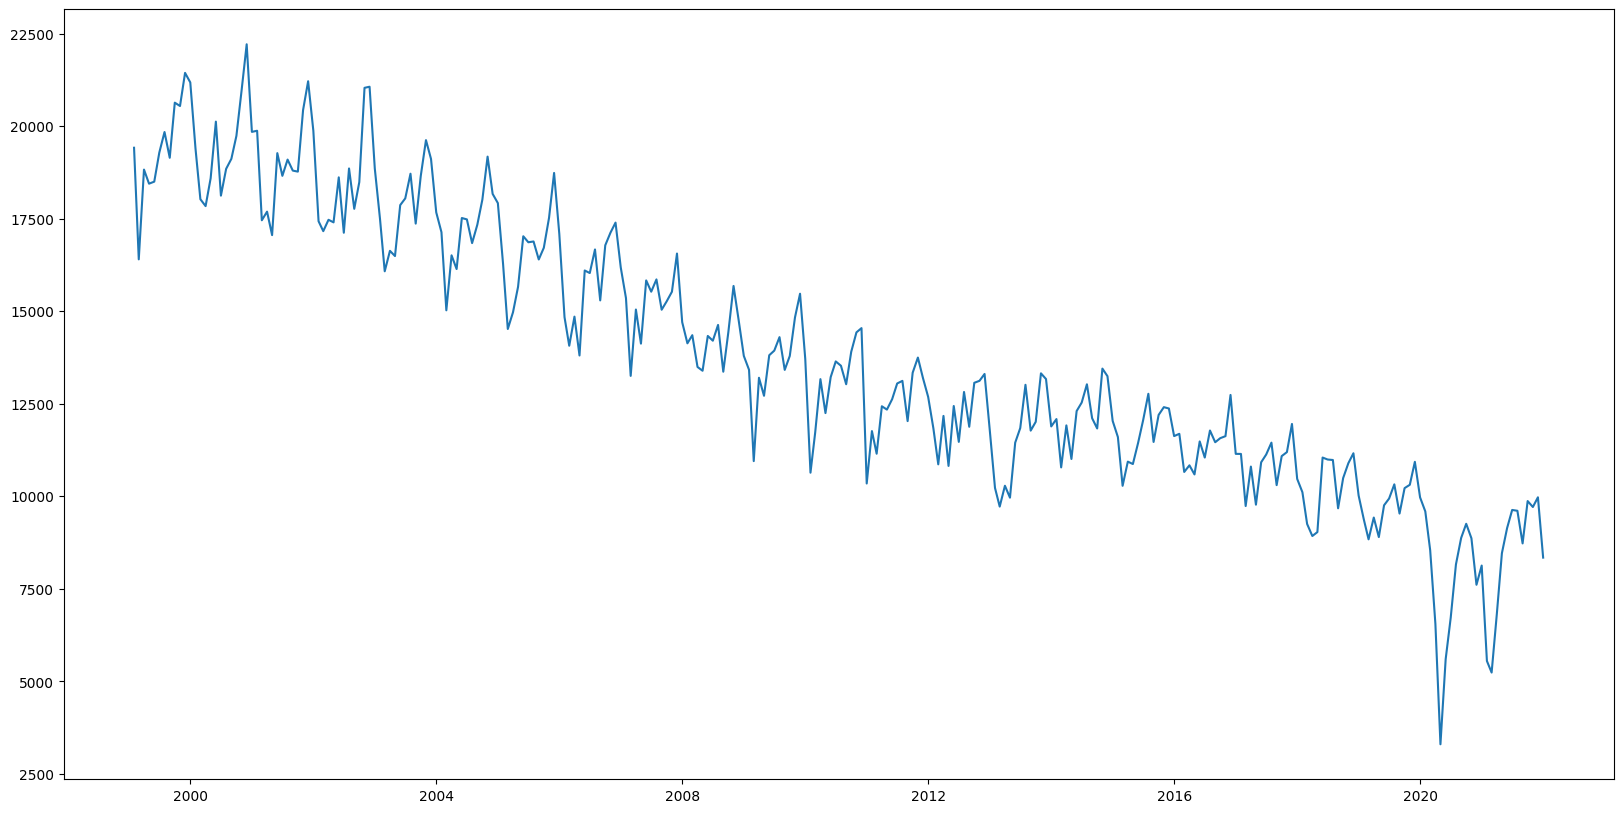

In [217]:
plt.figure(figsize=(20,10))
plt.plot(time_series);

Text(0.5, 1.0, 'Multiplicative residuals plot')

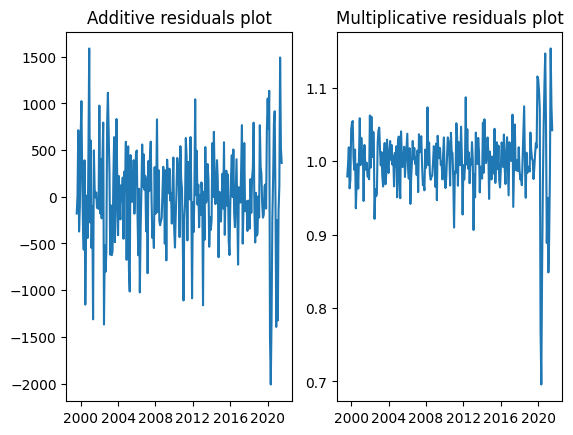

In [6]:
result_add_2019 = seasonal_decompose(time_series['Accidents'], model='additive')
result_mul_2019 = seasonal_decompose(time_series['Accidents'], model='multiplicative')
plt.subplot(1,2,1)
plt.plot(result_add_2019.resid)
plt.title('Additive residuals plot')
plt.subplot(1,2,2)
plt.plot(result_mul_2019.resid)
plt.title('Multiplicative residuals plot')

In [220]:
adfuller(time_series['Accidents'])[1]

0.7192577637165356

In [221]:
adfuller(result_add.resid.dropna())[1]

5.986858316453987e-11

In [222]:
adfuller(result_mul.resid.dropna())[1]

2.57326991610031e-10

In [7]:
time_series['deseasonalized']=time_series['Accidents'].values-result_add_2019.seasonal

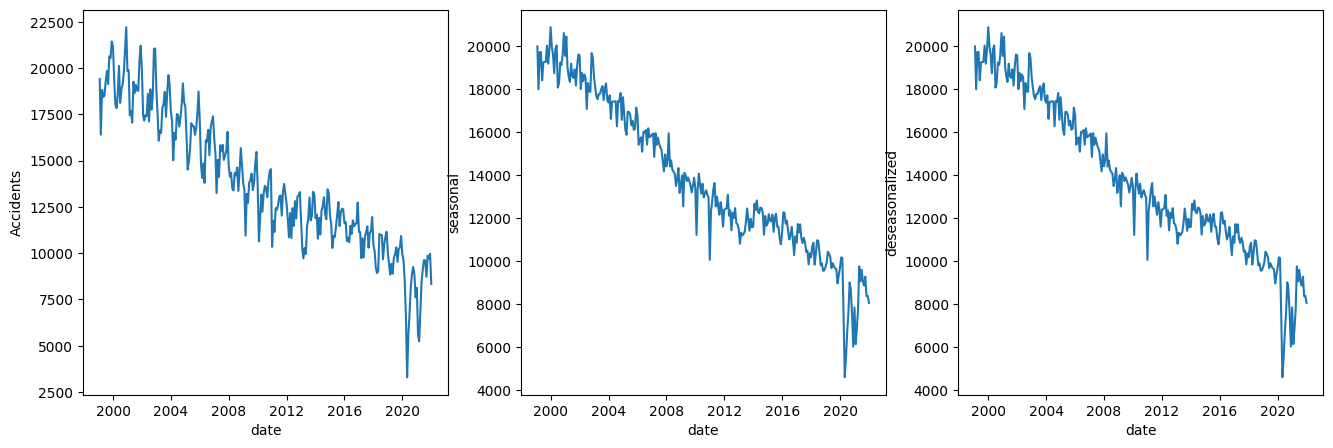

In [224]:
fig, axes = plt.subplots(1,3, figsize=(16,5))

sns.lineplot(time_series['Accidents'], ax=axes[0])
sns.lineplot(time_series['Accidents'].values-result_add_2019.seasonal, ax=axes[1])
sns.lineplot(time_series['deseasonalized'], ax=axes[2]);

In [8]:
time_series_2019=time_series.head(time_series.shape[0]-24)
time_series_2019

,Accidents,deseasonalized
date,,
1999-01-31,20072,19912.105745
1999-02-28,16830,18414.353851
1999-03-31,18825,19575.690972
1999-04-30,18989,19775.723169
1999-05-31,18963,18711.083018
...,...,...
2019-08-31,9869,9816.359533
2019-09-30,10157,9636.234533
2019-10-31,10003,9065.461806


/home/ele/.pyenv/versions/3.10.6/envs/UK-road-safety/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


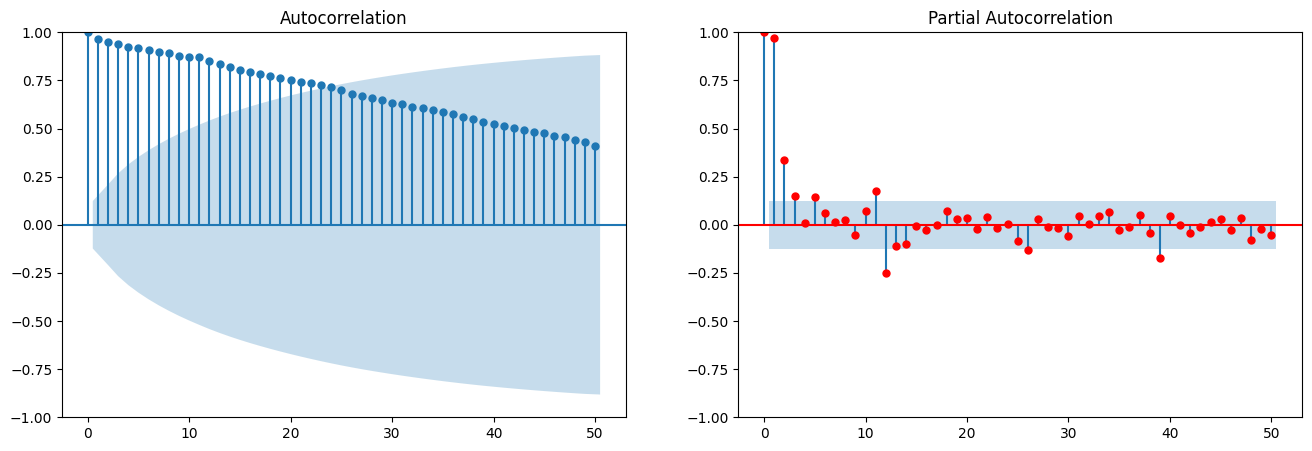

In [329]:
fig, axes = plt.subplots(1,2, figsize=(16,5))

plot_acf(time_series_2019['deseasonalized'], lags=50, ax=axes[0]);
plot_pacf(time_series_2019['deseasonalized'], lags=50, ax=axes[1], color='r');

In [234]:
ndiffs(time_series_2019['deseasonalized'])

1

In [11]:
train=time_series_2019['deseasonalized']
test=time_series['deseasonalized'][-24:]

In [13]:
smodel = pm.auto_arima(train,
                       start_p=1, max_p=4,
                       start_q=1, max_q=25,
                       trend='t',
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3866.018, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3955.581, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3890.734, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3864.623, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3955.581, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3866.521, Time=3.85 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3867.470, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3864.623, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 5.082 seconds


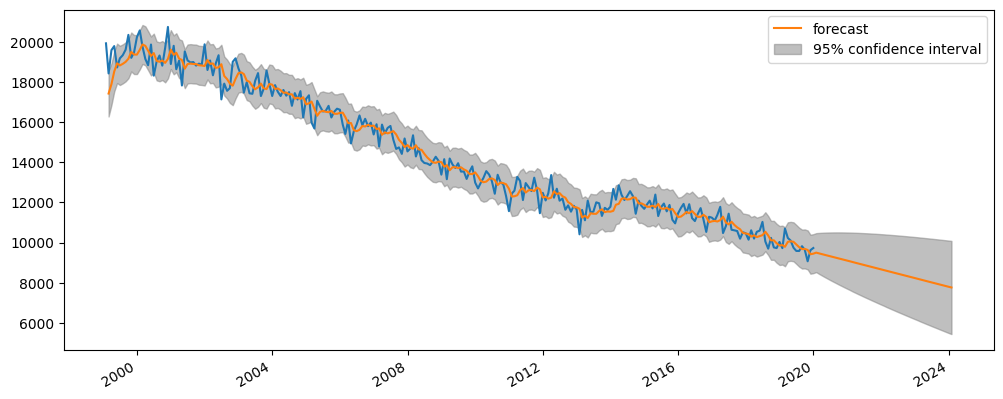

In [14]:
arima_2019 = ARIMA(train, order=(0, 1, 1), trend='t')
arima_2019 = arima_2019.fit()
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(time_series_2019['deseasonalized'])
plot_predict(arima_2019, start=1, end=300, ax=axs);

In [15]:


# We define here a "Plot forecast vs. real", which also shows historical training set

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);



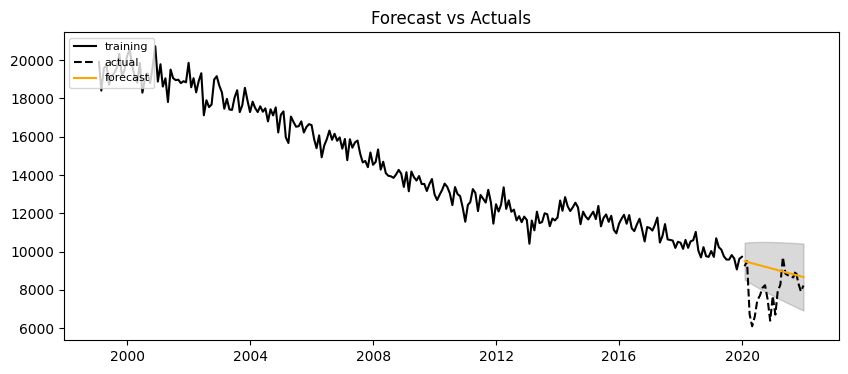

In [16]:

forecast_results = arima_2019.get_forecast(len(test), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values
plot_forecast(forecast, train, test, confidence_int[:,0], confidence_int[:,1])

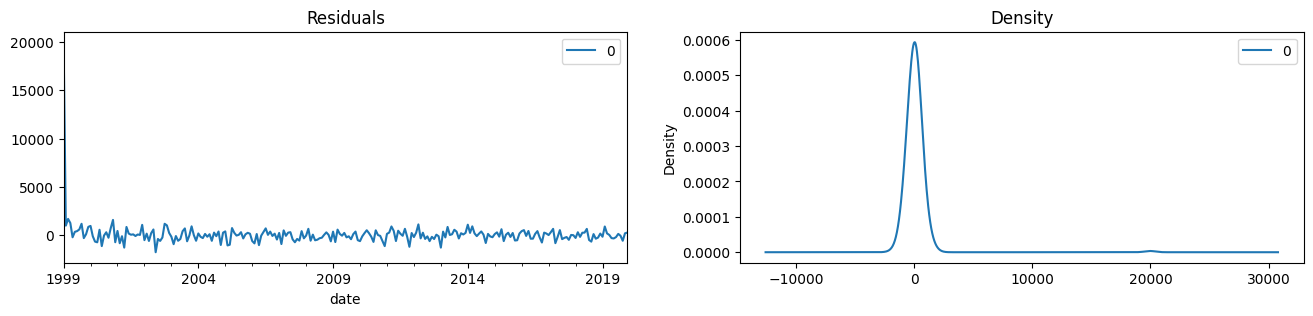

In [17]:


residuals = pd.DataFrame(arima_2019.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);



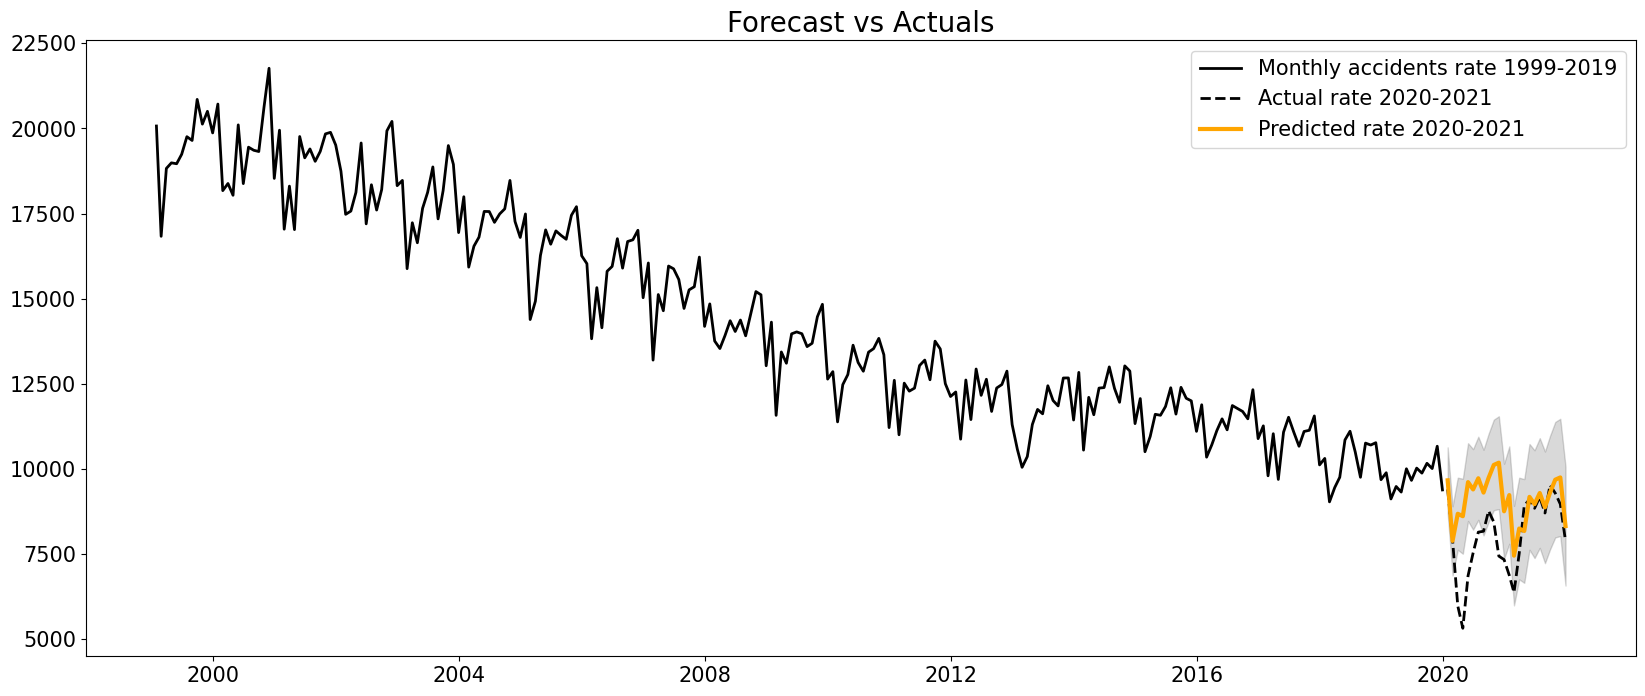

In [37]:
forecast_recons = forecast + result_add_2019.seasonal[len(train):]
train_recons = train+ result_add_2019.seasonal[0:len(train)]
test_recons = test+result_add_2019.seasonal[len(train):]
lower_recons =confidence_int[:, 0]+ result_add_2019.seasonal[len(train):]
upper_recons = confidence_int[:, 1] + result_add_2019.seasonal[len(train):]

plt.figure(figsize=(20,8))
plt.plot(train_recons, label='Monthly accidents rate 1999-2019', color='black',linewidth=2)
plt.plot(test_recons, label='Actual rate 2020-2021', color='black', ls='--',linewidth=2)
plt.plot(forecast_recons, label='Predicted rate 2020-2021', color='orange',linewidth=3)
plt.fill_between(lower_recons.index, lower_recons, upper_recons, color='k', alpha=.15)
plt.title('Forecast vs Actuals',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15);

In [283]:
data_2022=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-provisional-mid-year-unvalidated-2022.csv')
data_2022['date']=pd.to_datetime(data_2022['date'])
time_series_2022=pd.DataFrame(data_2022[['date','accident_index']].set_index('date').resample('M').size())
time_series_2022.columns=['Accidents']


/tmp/ipykernel_6272/3021790696.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data_2022['date']=pd.to_datetime(data_2022['date'])


## Using real data from 2020 and 2021

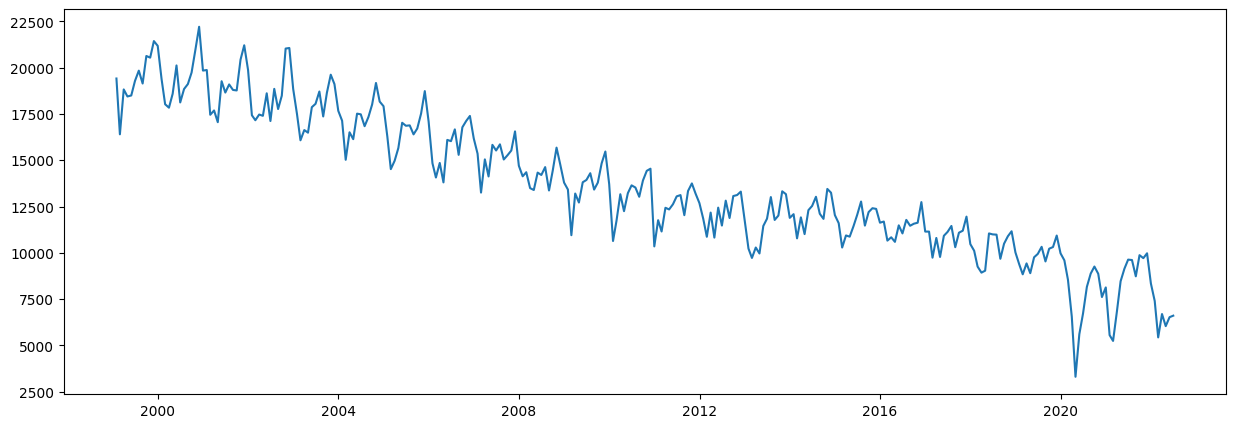

In [436]:
time_series_total=pd.concat([time_series,time_series_2022])
time_series_total=time_series_total[:time_series_total.shape[0]-6]
plt.figure(figsize=(15,5))
plt.plot(time_series_total['Accidents'])

Text(0.5, 1.0, 'Multiplicative residuals plot')

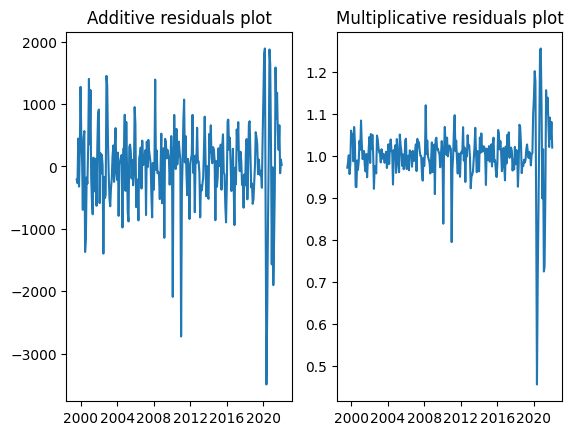

In [338]:
result_add = seasonal_decompose(time_series_total['Accidents'], model='additive')
result_mul = seasonal_decompose(time_series_total['Accidents'], model='multiplicative')
plt.subplot(1,2,1)
plt.plot(result_add.resid)
plt.title('Additive residuals plot')
plt.subplot(1,2,2)
plt.plot(result_mul.resid)
plt.title('Multiplicative residuals plot')

In [339]:
time_series_total['deseasonalized']=time_series_total['Accidents'].values-result_add.seasonal

In [340]:
train=time_series_total[:time_series_total.shape[0]-6]
test=time_series_total[time_series_total.shape[0]-6:]

In [341]:
smodel = pm.auto_arima(train['deseasonalized'],
                       start_p=1, max_p=10,
                       start_q=1, max_q=25,
                       trend='t',
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4392.602, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4439.508, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4414.707, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4407.677, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4439.508, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4393.811, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4394.093, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4400.337, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4412.751, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4395.547, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4392.602, Time=0.17 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.536 seconds


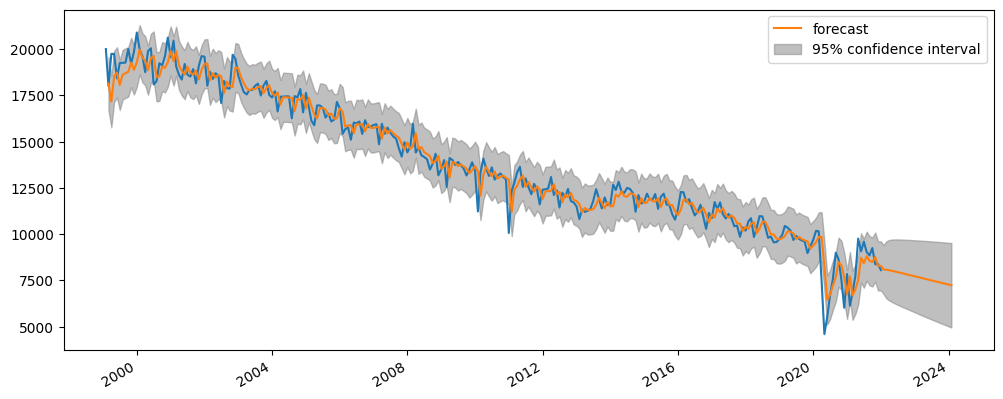

In [342]:
arima_total = ARIMA(train['deseasonalized'], order=(1, 1, 1), trend='t')
arima_total = arima_total.fit()
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(train['deseasonalized'])
plot_predict(arima_total, start=1, end=300, ax=axs);

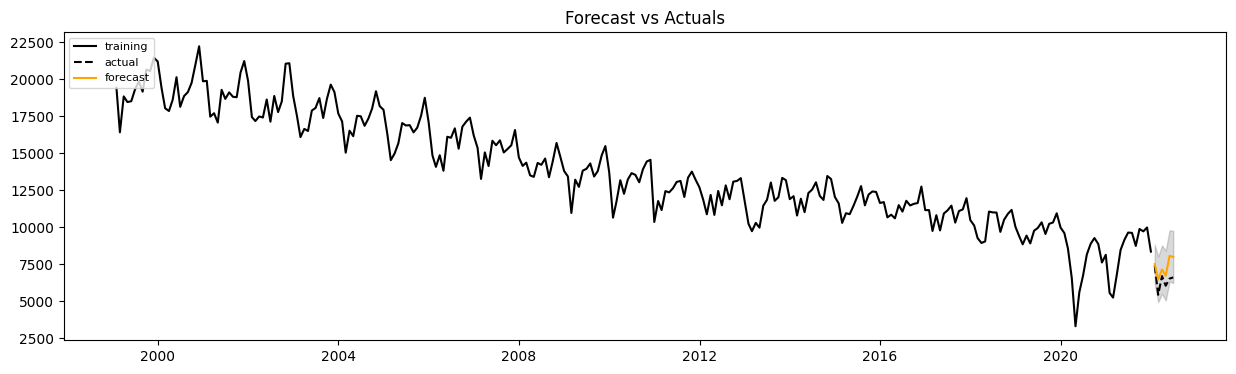

In [345]:
forecast_results = arima_total.get_forecast(len(test), alpha=0.05)
forecast_recons = forecast_results.predicted_mean+result_add.seasonal[len(train):]
confidence_int = forecast_results.conf_int().values
lower_series = pd.Series(confidence_int[:,0], index=test.index)+ result_add.seasonal[len(train):]
upper_series = pd.Series(confidence_int[:,1], index=test.index)+ result_add.seasonal[len(train):]
train_recons=train['deseasonalized']+ result_add.seasonal[:len(train)]
test_recons=test['deseasonalized']+ result_add.seasonal[len(train):]
plt.figure(figsize=(15,4))
plt.plot(train_recons, label='training', color='black')
plt.plot(test_recons, label='actual', color='black', ls='--')
plt.plot(forecast_recons, label='forecast', color='orange')
plt.fill_between(lower_series.index,lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8);

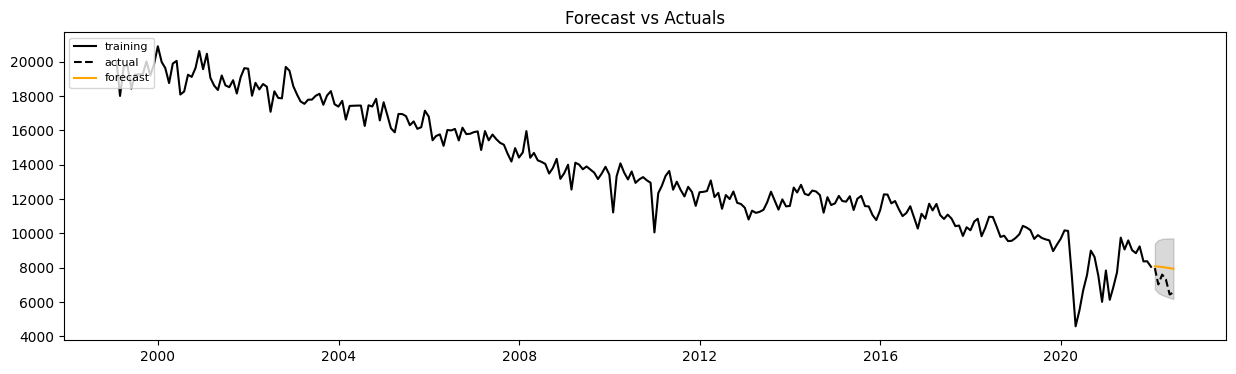

In [346]:
forecast_results = arima_total.get_forecast(len(test), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values
lower_series = pd.Series(confidence_int[:,0], index=test.index)
upper_series = pd.Series(confidence_int[:,1], index=test.index)
plt.figure(figsize=(15,4))
plt.plot(train['deseasonalized'], label='training', color='black')
plt.plot(test['deseasonalized'], label='actual', color='black', ls='--')
plt.plot(forecast, label='forecast', color='orange')
plt.fill_between(lower_series.index,lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8);

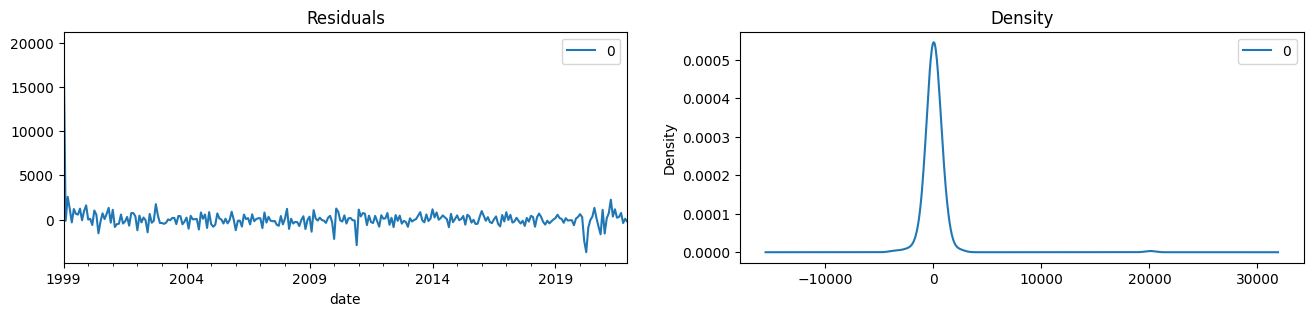

In [446]:
residuals = pd.DataFrame(arima_total.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);

## Using predicted data from 2020 and 2021

In [397]:
fc_2020_2021=pd.DataFrame((arima_2019.forecast(24, alpha=0.05)+result_add_2019.seasonal[len(time_series_2019['deseasonalized']):]).astype(int))
fc_2020_2021.columns=['Accidents']
fc_2020_2021.columns


Index(['Accidents'], dtype='object')

In [398]:
train=pd.concat([time_series_2019[['Accidents']],fc_2020_2021])

In [422]:
test=pd.DataFrame(time_series_total['Accidents'][time_series_total.shape[0]-6:])
test.columns=['Accidents']

In [424]:
time_series_final=pd.concat([train,test])
time_series_final.tail(10)

,Accidents
2021-09-30,9329
2021-10-31,10042
2021-11-30,10248
2021-12-31,8909
2022-01-31,7394
2022-02-28,5426
2022-03-31,6689
2022-04-30,6035
2022-05-31,6519
2022-06-30,6601


Text(0.5, 1.0, 'Multiplicative residuals plot')

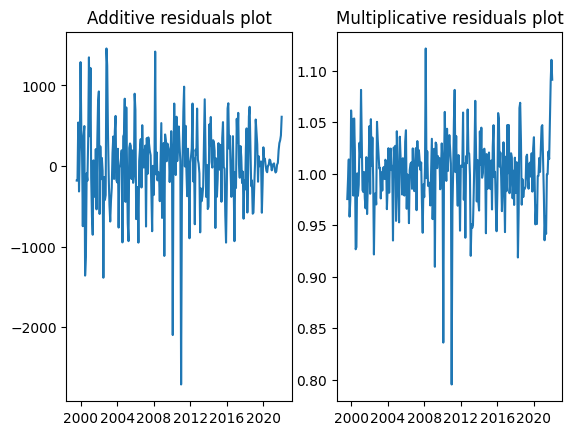

In [425]:
result_add = seasonal_decompose(time_series_final['Accidents'], model='additive')
result_mul = seasonal_decompose(time_series_final['Accidents'], model='multiplicative')
plt.subplot(1,2,1)
plt.plot(result_add.resid)
plt.title('Additive residuals plot')
plt.subplot(1,2,2)
plt.plot(result_mul.resid)
plt.title('Multiplicative residuals plot')

In [426]:
time_series_final['deseasonalized']=time_series_final['Accidents']/result_mul.seasonal

In [427]:
train_final=time_series_final['deseasonalized'][:len(train)]
test_final=time_series_final['deseasonalized'][len(train):]

In [428]:
smodel = pm.auto_arima(train_final,
                       start_p=1, max_p=10,
                       start_q=1, max_q=25,
                       trend='t',
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4288.136, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4377.436, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4323.348, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4292.128, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4377.436, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4290.400, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4290.063, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4289.375, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4308.278, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4288.136, Time=0.26 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 2.488 seconds


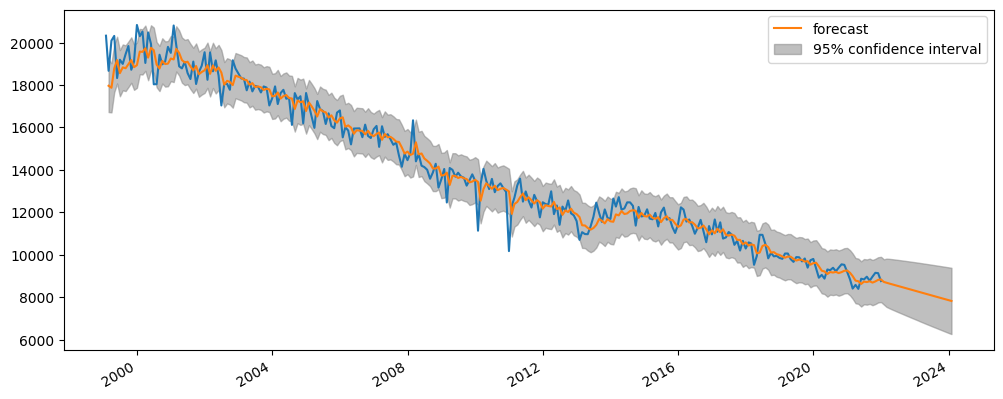

In [430]:
arima_final=ARIMA(train_final, order=(1, 1, 1), trend='t')
arima_final = arima_final.fit()
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(train_final)
plot_predict(arima_final, start=1, end=300, ax=axs);

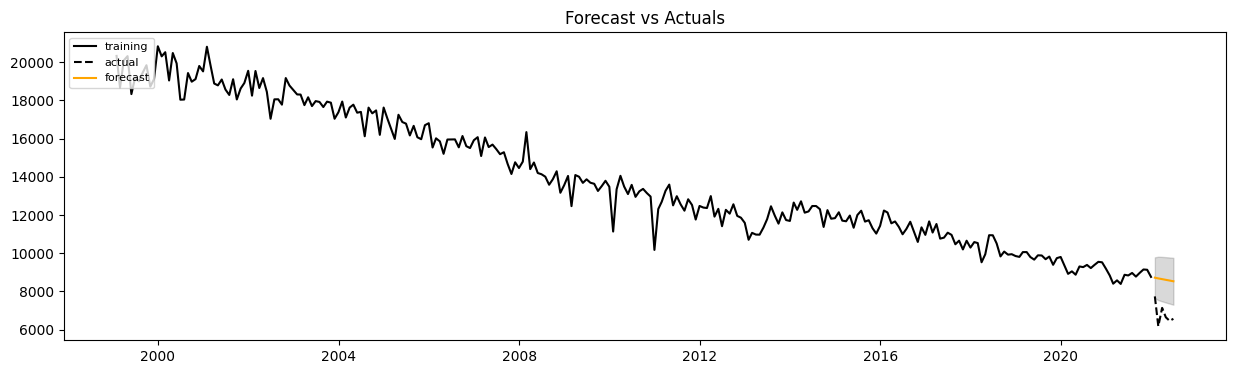

In [431]:
forecast_results = arima_final.get_forecast(len(test_final), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values
lower_series = pd.Series(confidence_int[:,0], index=test_final.index)
upper_series = pd.Series(confidence_int[:,1], index=test_final.index)
plt.figure(figsize=(15,4))
plt.plot(train_final, label='training', color='black')
plt.plot(test_final, label='actual', color='black', ls='--')
plt.plot(forecast, label='forecast', color='orange')
plt.fill_between(lower_series.index,lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8);

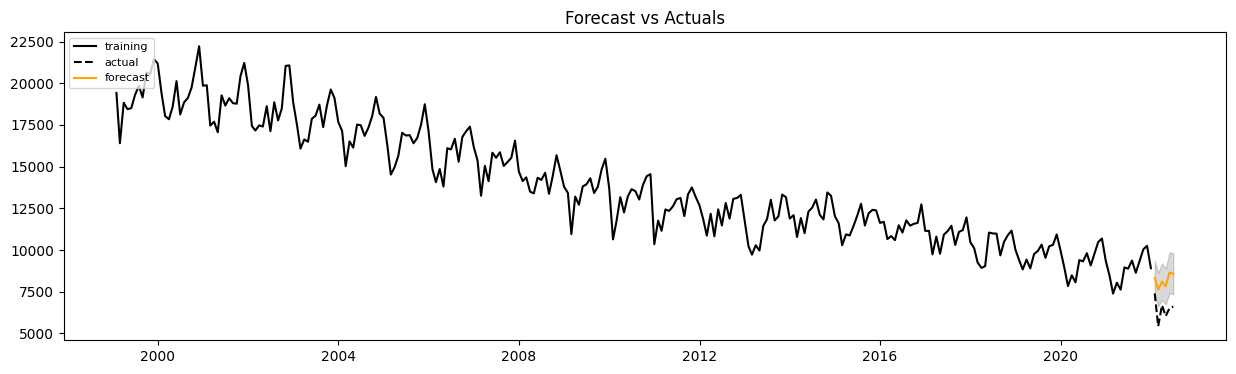

In [433]:
forecast_results = arima_final.get_forecast(len(test_final), alpha=0.05)
forecast_recons = forecast_results.predicted_mean*result_mul.seasonal[len(train_final):]
confidence_int = forecast_results.conf_int().values
lower_series = pd.Series(confidence_int[:,0], index=test_final.index)*result_mul.seasonal[len(train_final):]
upper_series = pd.Series(confidence_int[:,1], index=test_final.index)*result_mul.seasonal[len(train_final):]
train_recons=train_final*result_mul.seasonal[:len(train_final)]
test_recons=test_final*result_mul.seasonal[len(train_final):]
plt.figure(figsize=(15,4))
plt.plot(train_recons, label='training', color='black')
plt.plot(test_recons, label='actual', color='black', ls='--')
plt.plot(forecast_recons, label='forecast', color='orange')
plt.fill_between(lower_series.index,lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8);

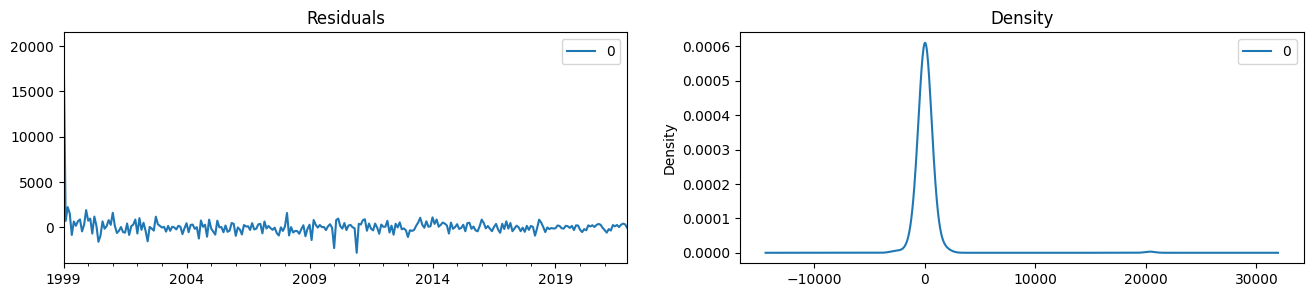

In [445]:
residuals = pd.DataFrame(arima_final.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);

# Geohashes

In [447]:
data_sets={'gcpvj0':df_accidents[df_accidents['geohash']=='gcpvj0'],
           'gcpvhc':df_accidents[df_accidents['geohash']=='gcpvhc'],
           'gcpvj4':df_accidents[df_accidents['geohash']=='gcpvj4'],
           'gcpvj1':df_accidents[df_accidents['geohash']=='gcpvj1'],
           'gcpuv2':df_accidents[df_accidents['geohash']=='gcpuv2']}

In [448]:
ts={'gcpvj0':data_for_analysis(data_sets['gcpvj0']),
           'gcpvhc':data_for_analysis(data_sets['gcpvhc']),
           'gcpvj4':data_for_analysis(data_sets['gcpvj4']),
           'gcpvj1':data_for_analysis(data_sets['gcpvj1']),
           'gcpuv2':data_for_analysis(data_sets['gcpuv2'])}

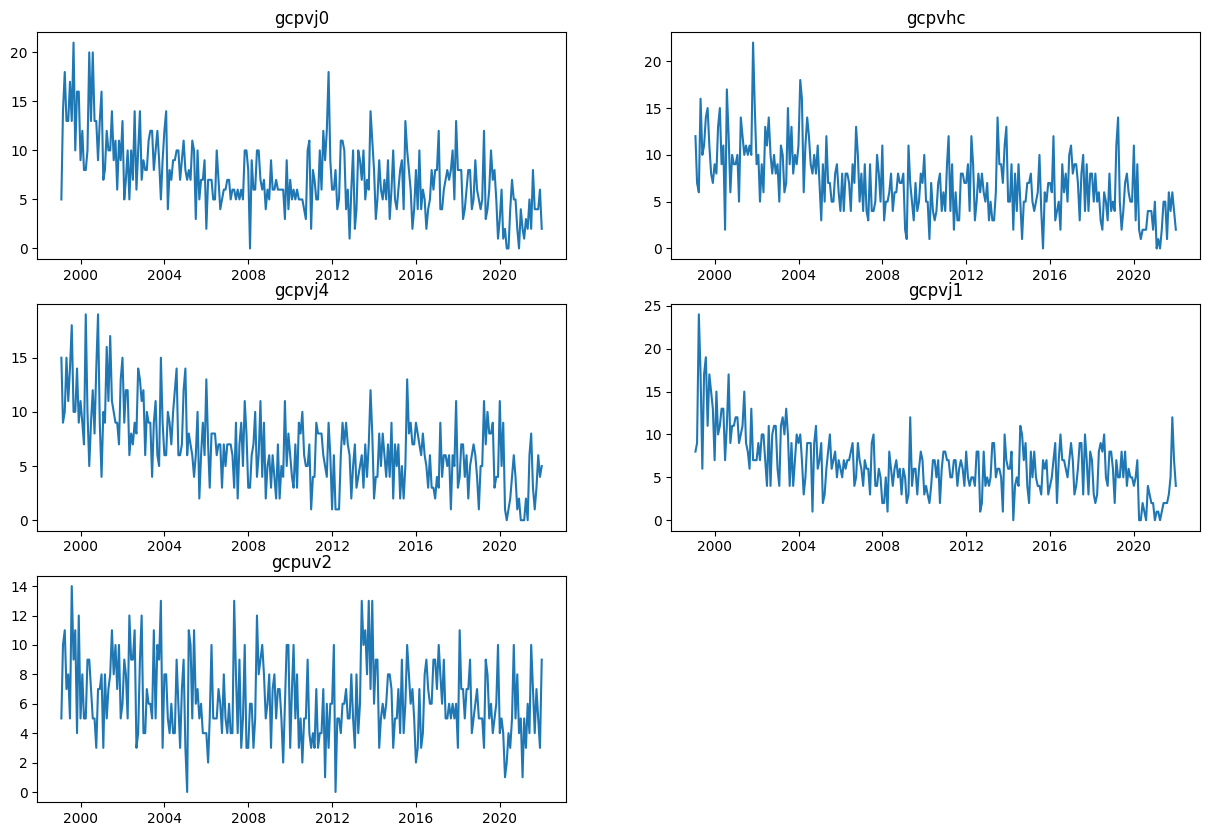

In [456]:
plt.figure(figsize=(15,10))
for i,k in enumerate(ts.keys()):
    plt.subplot(3,2,i+1)
    plt.plot(ts[k])
    plt.title(k)

In [458]:
ts['gcpuv2'].shape[0]-24

252

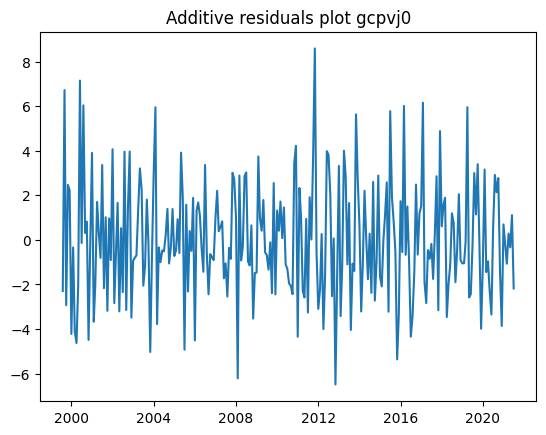

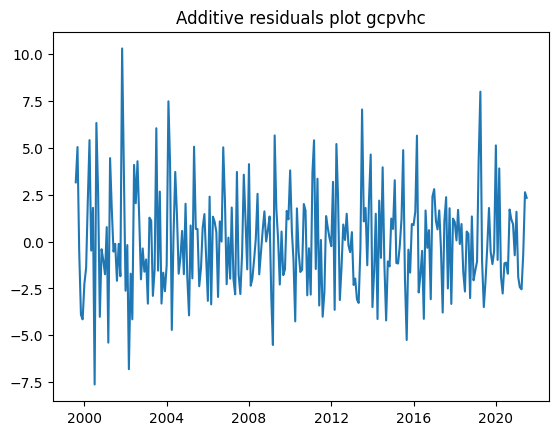

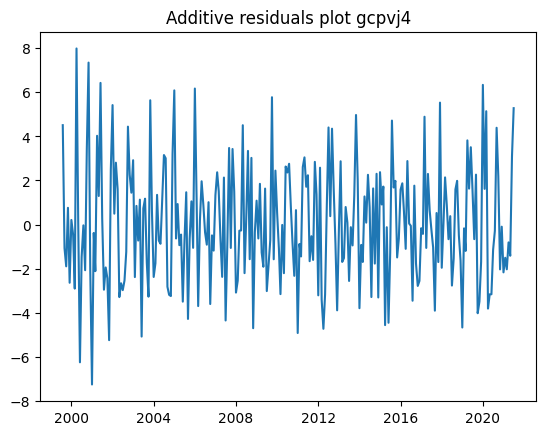

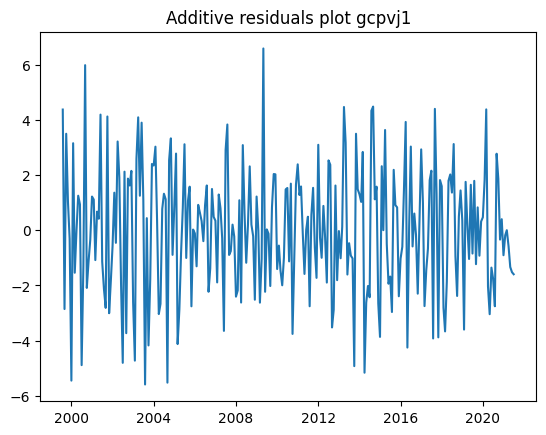

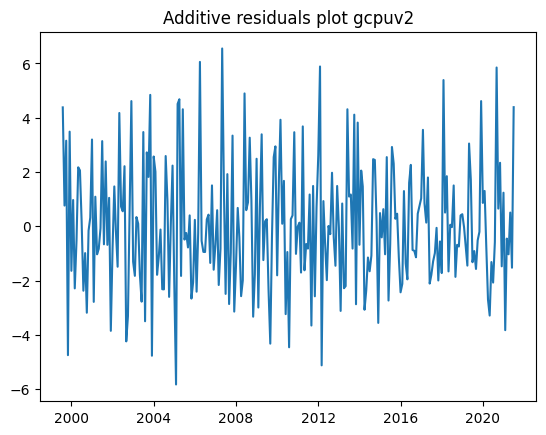

In [499]:
ts_des={}
add={}
for k in ts.keys():
    result_add_k = seasonal_decompose(ts[k], model='additive')
    add[k]=result_add_k
    ts_des[k]=ts[k]['Accidents'].values-result_add_k.seasonal
    plt.plot(result_add_k.resid)
    plt.title('Additive residuals plot '+k)
    plt.show()

In [491]:
ts_train={}
for k in ts_des.keys():
    ts_train[k]=ts_des[k][:252]
ts_test={}
for k in ts_des.keys():
    ts_test[k]=ts_des[k][252:]

In [493]:
for k in ts_train.keys():
    print('Geohash '+k)
    smodel = pm.auto_arima(ts_train[k], seasonal=True, 
                       start_p=0, max_p=5,
                       start_P=0, max_P=5, 
                       trace=True, error_action='ignore', suppress_warnings=True)

Geohash gcpvj0
Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1251.483, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1392.906, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1324.420, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1249.484, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1390.908, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1251.483, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1253.484, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1250.316, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.607 seconds
Geohash gcpvhc
Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1275.932, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1413.536, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1359.484, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1275.001, Time=0.09 sec
 ARIMA(0,1,0)(0

In [506]:
forecasts={}
conf_ints={}

In [ ]:
arima_gcpvj0 = ARIMA(ts_train['gcpvj0'], order=(0,1,1), trend='t')
arima_gcpvj0 = arima_gcpvj0.fit()
forecast_results_gcpvj0 = arima_gcpvj0.get_forecast(len(ts_test['gcpvj0']), alpha=0.05)
forecast_gcpvj0 = forecast_results_gcpvj0.predicted_mean
forecast['gcpvj0'] = forecast_gcpvj0
confidence_int_gcpvj0 = forecast_results.conf_int().values
conf_ints['gcpvj0']=confidence_int_gcpvj0




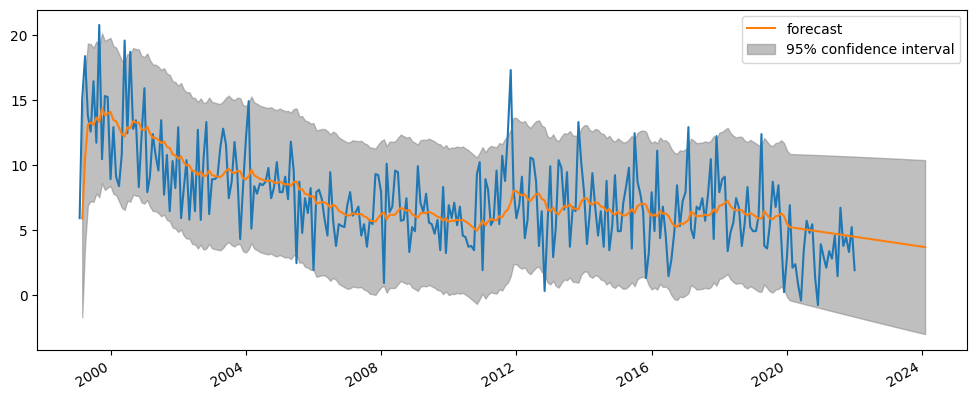

In [525]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(ts_des['gcpvj0'])
plot_predict(arima_gcpvj0, start=1, end=300, ax=axs);


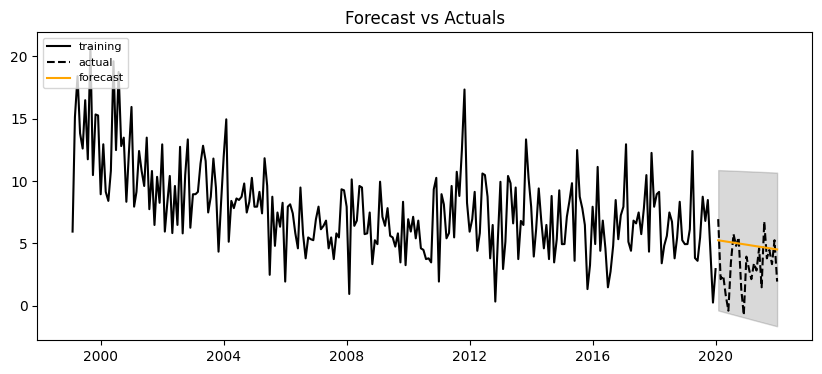

In [526]:
plot_forecast(forecast, ts_train['gcpvj0'], ts_test['gcpvj0'], confidence_int[:,0], confidence_int[:,1])

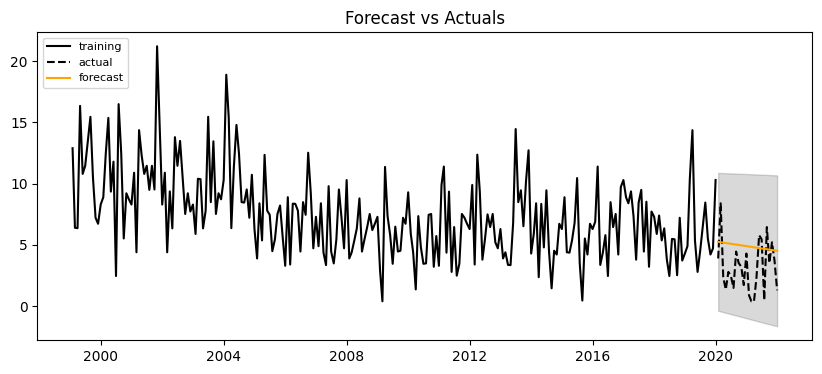

In [511]:
arima_gcpvhc = ARIMA(ts_train['gcpvhc'], order=(0,1,1), trend='t')
arima_gcpvhc = arima_gcpvhc.fit()
forecast_results_gcpvhc = arima_gcpvhc.get_forecast(len(ts_test['gcpvhc']), alpha=0.05)
forecast_gcpvhc = forecast_results_gcpvhc.predicted_mean
forecast['gcpvhc'] = forecast_gcpvhc
confidence_int_gcpvhc = forecast_results.conf_int().values
conf_ints['gcpvhc']=confidence_int_gcpvhc
plot_forecast(forecast, ts_train['gcpvhc'], ts_test['gcpvhc'], confidence_int[:,0], confidence_int[:,1])

    

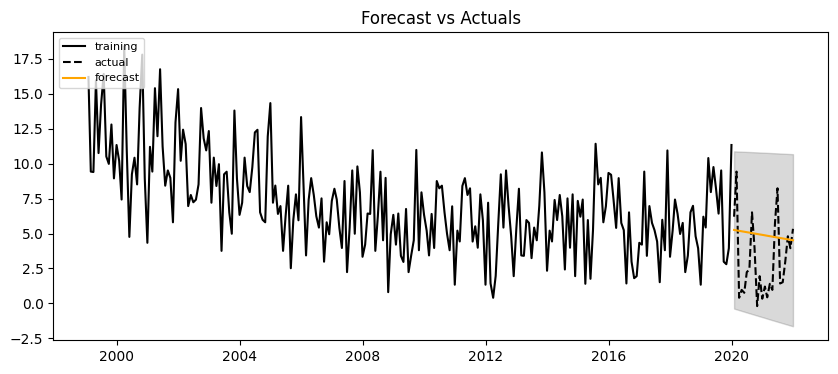

In [510]:
arima_gcpvj4 = ARIMA(ts_train['gcpvj4'], order=(0,1,1), trend='t')
arima_gcpvj4 = arima_gcpvj4.fit()
forecast_results_gcpvj4 = arima_gcpvj4.get_forecast(len(ts_test['gcpvj4']), alpha=0.05)
forecast_gcpvj4 = forecast_results_gcpvj4.predicted_mean
forecast['gcpvj4'] = forecast_gcpvj4
confidence_int_gcpvj4 = forecast_results.conf_int().values
conf_ints['gcpvj4']=confidence_int_gcpvj4
plot_forecast(forecast, ts_train['gcpvj4'], ts_test['gcpvj4'], confidence_int[:,0], confidence_int[:,1])

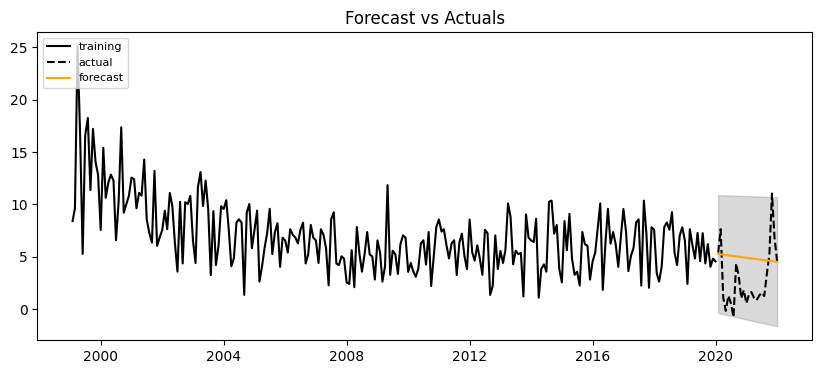

In [512]:
arima_gcpvj1 = ARIMA(ts_train['gcpvj1'], order=(2,1,1), trend='t')
arima_gcpvj1 = arima_gcpvj1.fit()
forecast_results_gcpvj1 = arima_gcpvj1.get_forecast(len(ts_test['gcpvj1']), alpha=0.05)
forecast_gcpvj1 = forecast_results_gcpvj1.predicted_mean
forecast['gcpvj1'] = forecast_gcpvj1
confidence_int_gcpvj1 = forecast_results.conf_int().values
conf_ints['gcpvj1']=confidence_int_gcpvj1
plot_forecast(forecast, ts_train['gcpvj1'], ts_test['gcpvj1'], confidence_int[:,0], confidence_int[:,1])

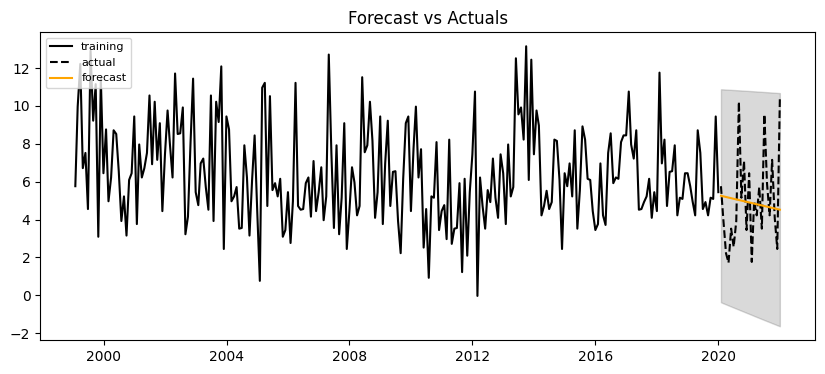

In [513]:
arima_gcpuv2 = ARIMA(ts_train['gcpuv2'], order=(2,1,1), trend='t')
arima_gcpuv2 = arima_gcpuv2.fit()
forecast_results_gcpuv2 = arima_gcpuv2.get_forecast(len(ts_test['gcpuv2']), alpha=0.05)
forecast_gcpuv2 = forecast_results_gcpuv2.predicted_mean
forecast['gcpuv2'] = forecast_gcpuv2
confidence_int_gcpuv2 = forecast_results.conf_int().values
conf_ints['gcpuv2']=confidence_int_gcpuv2
plot_forecast(forecast, ts_train['gcpuv2'], ts_test['gcpuv2'], confidence_int[:,0], confidence_int[:,1])

In [521]:
for_recs={}
train_recs={}
test_recs={}
low_conf_recs={}
up_conf_recs={}
for k in ts.keys():
    for_recs[k]=forecast[k]+add[k].seasonal[252:]
    train_recs[k]=ts_train[k]+add[k].seasonal[:252]
    test_recs[k]=ts_test[k]+add[k].seasonal[252:]
    low_conf_recs[k]=conf_ints[k][:,0]+add[k].seasonal[252:]
    up_conf_recs[k]=conf_ints[k][:,1]+add[k].seasonal[252:]

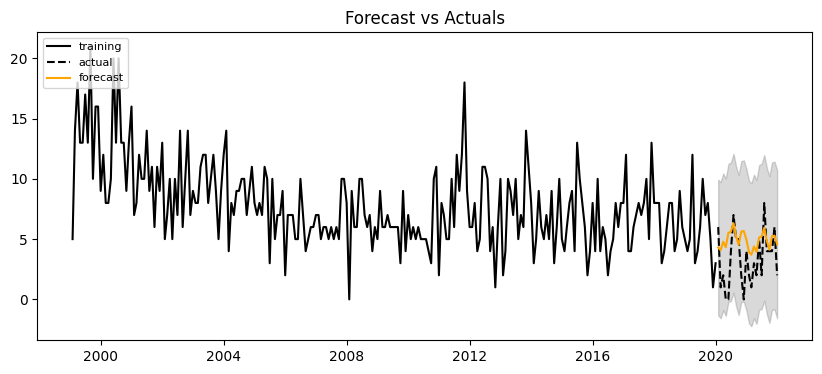

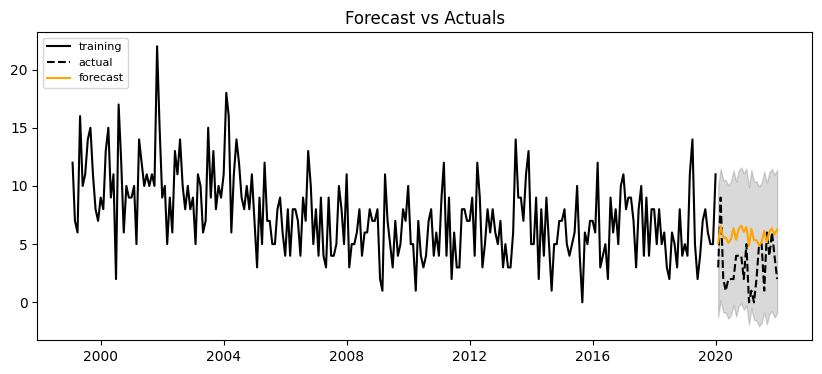

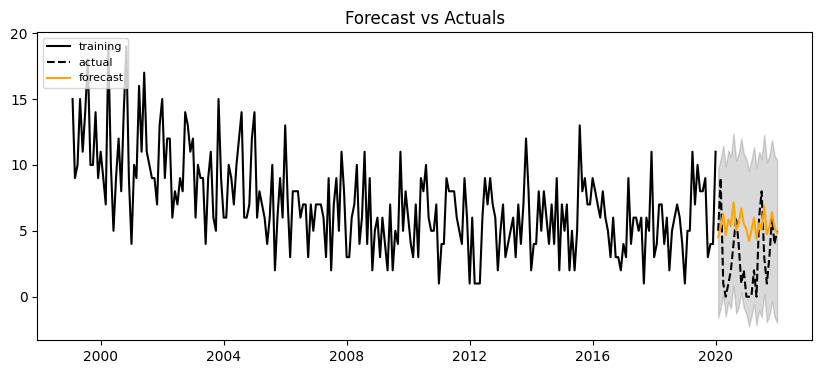

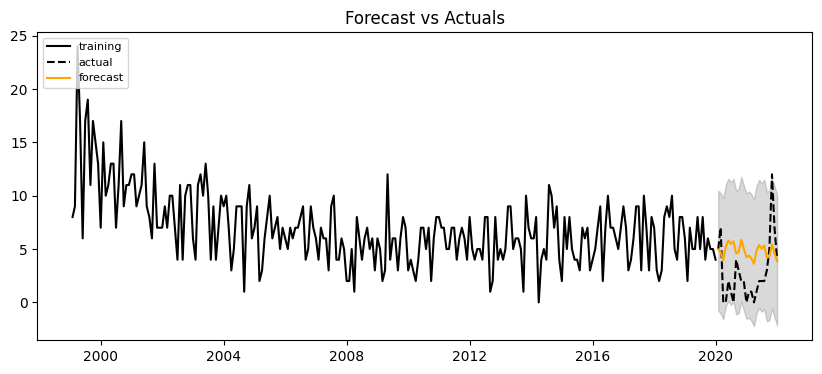

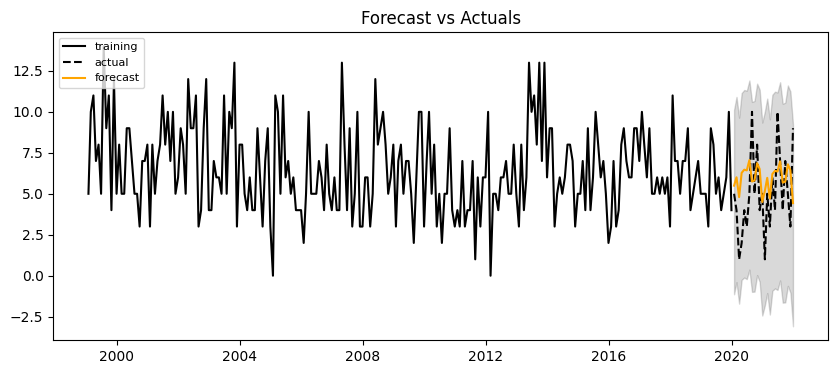

In [524]:
for k in ts.keys():
    plot_forecast(for_recs[k], train_recs[k], test_recs[k], low_conf_recs[k].values, up_conf_recs[k].values)

date
2020-01-31   -0.950758
2020-02-29   -1.136364
2020-03-31   -0.410985
2020-04-30   -0.831439
2020-05-31    0.392045
2020-06-30    0.515152
2020-07-31    1.253788
2020-08-31    0.193182
2020-09-30   -0.481061
2020-10-31    0.659091
2020-11-30    0.740530
2020-12-31    0.056818
2021-01-31   -0.950758
2021-02-28   -1.136364
2021-03-31   -0.410985
2021-04-30   -0.831439
2021-05-31    0.392045
2021-06-30    0.515152
2021-07-31    1.253788
2021-08-31    0.193182
2021-09-30   -0.481061
2021-10-31    0.659091
2021-11-30    0.740530
2021-12-31    0.056818
Freq: M, Name: seasonal, dtype: float64

### Sarima

In [460]:
for k in ts.keys():
    print('Geohash '+k)
    smodel = pm.auto_arima(ts_train[k], seasonal=True, m=12, 
                       start_p=0, max_p=5, max_d=2, start_q=0, max_q=5,
                       start_P=0, max_P=5, max_D=5, start_Q=0, max_Q=5, 
                       trace=True, error_action='ignore', suppress_warnings=True)



Geohash gcpvj0
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1403.190, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1342.280, Time=1.40 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1267.442, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1401.191, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1266.939, Time=0.17 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1267.356, Time=0.96 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1269.306, Time=1.90 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1268.587, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=1268.586, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1341.796, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1270.586, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=1267.637, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12] intercept
Total fit time: 6.467 seconds
Geohash gcpvhc
Performing stepwise search to minimize aic
 A

In [ ]:
sarima_gcpvj0=SARIMAX(ts_train['gcpvj0'], order=(0, 1, 1), seasonal_order=(0, 0, 0, 12))
sarima_gcpvj0=sarima_gcpvj0.fit(maxiter=75)

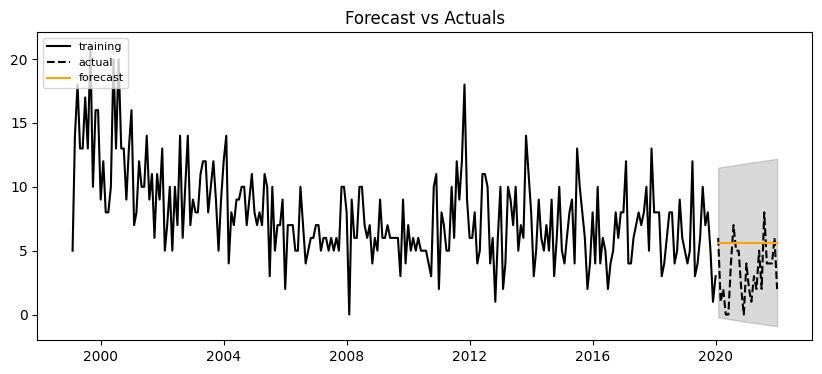

In [478]:
results = sarima_gcpvj0.get_forecast(len(ts_test['gcpvj0']), alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()
plot_forecast(forecast, ts_train['gcpvj0'], ts_test['gcpvj0'] ,upper = confidence_int['upper Accidents'].values, lower=confidence_int['lower Accidents'].values
              )

In [472]:
confidence_int

,lower Accidents,upper Accidents
2020-01-31,-0.222818,11.495015
2020-02-29,-0.254744,11.526942
2020-03-31,-0.286498,11.558696
2020-04-30,-0.318083,11.590281
2020-05-31,-0.349502,11.621699
...,...,...
2040-08-31,-5.632591,16.904789
2040-09-30,-5.649223,16.921421
2040-10-31,-5.665831,16.938029
2040-11-30,-5.682415,16.954612


In [463]:
sarima_gcpvhc=SARIMAX(train, order=(1, 1, 2), seasonal_order=(0, 0, 0, 12))
sarima_gcpvhc.fit(maxiter=75)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34832D+00    |proj g|=  1.27924D-01

At iterate    5    f=  8.34084D+00    |proj g|=  2.81567D-02

At iterate   10    f=  8.30808D+00    |proj g|=  6.30940D-02

At iterate   15    f=  8.28291D+00    |proj g|=  4.81648D-02

At iterate   20    f=  8.26891D+00    |proj g|=  8.07347D-03

At iterate   25    f=  8.26614D+00    |proj g|=  1.11017D-02

At iterate   30    f=  8.26547D+00    |proj g|=  9.32986D-04

At iterate   35    f=  8.26514D+00    |proj g|=  2.65557D-03

At iterate   40    f=  8.26246D+00    |proj g|=  1.22064D-02

At iterate   45    f=  8.25887D+00    |proj g|=  1.46140D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

In [464]:
sarima_gcpvj4=SARIMAX(train, order=(0, 1, 1), seasonal_order=(0, 0, 0, 12))
sarima_gcpvj4.fit(maxiter=75)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34739D+00    |proj g|=  8.45046D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      6      1     0     0   1.082D-06   8.345D+00
  F =   8.3445084523490447     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [465]:
sarima_gcpvj1=SARIMAX(train, order=(2, 1, 1), seasonal_order=(0, 0, 0, 12))
sarima_gcpvj1.fit(maxiter=75)

/home/ele/.pyenv/versions/3.10.6/envs/UK-road-safety/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ele/.pyenv/versions/3.10.6/envs/UK-road-safety/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.38111D+00    |proj g|=  3.23749D-01

At iterate    5    f=  8.34314D+00    |proj g|=  4.62391D-02

At iterate   10    f=  8.31421D+00    |proj g|=  4.48178D-02

At iterate   15    f=  8.27984D+00    |proj g|=  1.74326D-02

At iterate   20    f=  8.26450D+00    |proj g|=  6.43895D-03

At iterate   25    f=  8.26064D+00    |proj g|=  5.82912D-03

At iterate   30    f=  8.25970D+00    |proj g|=  8.77845D-04

At iterate   35    f=  8.25947D+00    |proj g|=  7.10619D-05

At iterate   40    f=  8.25940D+00    |proj g|=  1.59855D-03

At iterate   45    f=  8.25930D+00    |proj g|=  2.06994D-03

At iterate   50    f=  8.25910D+00    |proj g|=  1.02693D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [466]:
sarima_gcpuv2=SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 0, 12))
sarima_gcpuv2.fit(maxiter=75)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.31494D+00    |proj g|=  3.24677D-01


 This problem is unconstrained.



At iterate    5    f=  8.14780D+00    |proj g|=  1.35973D-02

At iterate   10    f=  8.13394D+00    |proj g|=  1.00899D-03

At iterate   15    f=  8.12790D+00    |proj g|=  6.88275D-03

At iterate   20    f=  8.07475D+00    |proj g|=  2.36351D-02

At iterate   25    f=  8.02081D+00    |proj g|=  1.14364D-02

At iterate   30    f=  8.01828D+00    |proj g|=  1.13366D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     47      1     0     0   9.226D-05   8.018D+00
  F =   8.0182770325681254     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
